In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from functools import reduce

## **EDA**

In [3]:
df = pd.read_csv('../data/zillow_data.csv')

In [4]:
df = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')

In [5]:
df.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04,334200.0
1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04,235700.0
2,77494,91982,3,Katy,TX,Houston,Harris,1996-04,210400.0
3,60614,84616,4,Chicago,IL,Chicago,Cook,1996-04,498100.0
4,79936,93144,5,El Paso,TX,El Paso,El Paso,1996-04,77300.0


In [6]:
df['time'].max()

'2018-04'

In [7]:
state_df = df.groupby(['State', 'time']).median().drop(['RegionName', 'RegionID', 'SizeRank'], axis = 1)

In [8]:
state_df = state_df.reset_index()

In [9]:
state_df_2013 = state_df[state_df['time'] == '2013-04']

In [10]:
state_df_2013.rename({'value': '2013_price'}, axis=1, inplace = True)
state_df_2013.drop('time', axis = 1, inplace = True)

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
state_df_2018 = state_df[state_df['time'] == '2018-04']
state_df_2018.rename({'value': '2018_price'}, axis=1, inplace = True)
state_df_2018.drop('time', axis = 1, inplace = True)

In [12]:
state_df_2013_2018 = state_df_2013.merge(state_df_2018, left_on= 'State', right_on='State')
state_df_2013_2018.head()

,State,2013_price,2018_price
0,AK,278900.0,312100.0
1,AL,121800.0,140500.0
2,AR,111000.0,132500.0
3,AZ,168150.0,238450.0
4,CA,362800.0,564700.0


In [13]:
state_df_2013_2018['5_year_change(%)'] = ((state_df_2013_2018['2018_price'] - state_df_2013_2018['2013_price']) / state_df_2013_2018['2013_price']) * 100

In [14]:
state_df_2013_2018.sort_values('5_year_change(%)', ascending=False)

,State,2013_price,2018_price,5_year_change(%)
33,NV,174600.0,287600.0,64.719359
9,FL,137700.0,226100.0,64.197531
5,CO,225700.0,365800.0,62.073549
7,DC,497250.0,785750.0,58.019105
47,WA,213600.0,333800.0,56.273408
4,CA,362800.0,564700.0,55.650496
37,OR,193600.0,298350.0,54.106405
44,UT,198000.0,291500.0,47.222222
13,ID,141900.0,206850.0,45.771670
22,MI,105250.0,150900.0,43.372922


In [15]:
state_df_2013_2018.to_csv('state_df_2013_2018.csv')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3901595 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RegionName  int64  
 1   RegionID    int64  
 2   SizeRank    int64  
 3   City        object 
 4   State       object 
 5   Metro       object 
 6   CountyName  object 
 7   time        object 
 8   value       float64
dtypes: float64(1), int64(3), object(5)
memory usage: 267.9+ MB


In [17]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m', errors= 'coerce')
df.set_index('time', inplace=True)

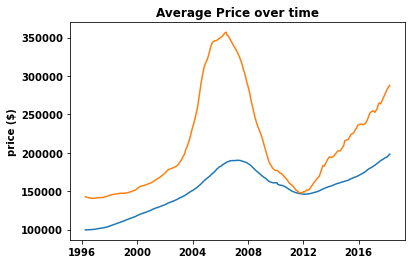

In [18]:
fig, ax = plt.subplots()
ax.set_title('Average Price over time')
ax.set_ylabel('price ($)')
ax.plot(df.groupby('time').median()['value'])
ax.plot(df[df['State'] == 'NV'].groupby('time').median()['value'])
plt.legend;

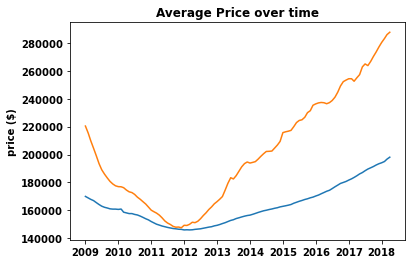

In [19]:
fig, ax = plt.subplots()
ax.set_title('Average Price over time')
ax.set_ylabel('price ($)')
ax.plot(df.groupby('time').median()['value'].loc['2009-01-01':])
ax.plot(df[df['State'] == 'NV'].groupby('time').median()['value'].loc['2009-01-01':])
plt.legend;

## **Preprocessing**

In [19]:
df_nv = df[df['State'] == 'NV']

In [20]:
df_nv.isna().sum()

RegionName       0
RegionID         0
SizeRank         0
City             0
State            0
Metro            0
CountyName       0
value         2469
dtype: int64

In [21]:
df_nv.dropna(inplace =True)

<ipython-input-21-9e60624c31bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nv.dropna(inplace =True)


In [22]:
df_nv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24826 entries, 1996-04-01 to 2018-04-01
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   RegionName  24826 non-null  int64  
 1   RegionID    24826 non-null  int64  
 2   SizeRank    24826 non-null  int64  
 3   City        24826 non-null  object 
 4   State       24826 non-null  object 
 5   Metro       24826 non-null  object 
 6   CountyName  24826 non-null  object 
 7   value       24826 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 1.7+ MB


In [23]:
df_nv.drop(['RegionID', 'State'], axis = 1, inplace = True)

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [24]:
df_nv_2013 = df_nv.reset_index()[df_nv.reset_index()['time'] == '2013-04']

In [25]:
df_nv_2013 = df_nv_2013.set_index('time')[['RegionName', 'value']].rename({'value': '2013_price'}, axis = 1)

In [26]:
df_nv_2018 = df_nv.reset_index()[df_nv.reset_index()['time'] == '2018-04']

In [27]:
df_nv_2018 = df_nv_2018.set_index('time')[['RegionName', 'value']].rename({'value': '2018_price'}, axis = 1)

In [28]:
df_nv_2013_2018 = df_nv_2013.merge(df_nv_2018, left_on= 'RegionName', right_on='RegionName')

In [29]:
df_nv_2013_2018['5_year_change(%)'] = ((df_nv_2013_2018['2018_price'] - df_nv_2013_2018['2013_price']) / df_nv_2013_2018['2013_price']) * 100


In [30]:
df_nv_2013_2018.to_csv('more_data/df_nv_2013_2018.csv')

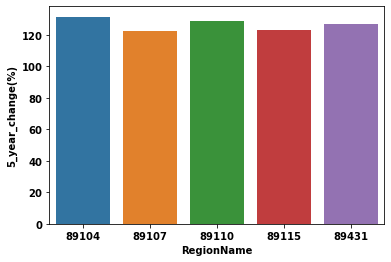

In [31]:
sns.barplot(data = df_nv_2013_2018.sort_values(by = '5_year_change(%)', ascending = False)[['RegionName', '5_year_change(%)']][:5], x = 'RegionName', y = '5_year_change(%)');


In [32]:
df_nv_5y_regions = df_nv['2013-04':][['RegionName', 'value']]
df_nv_5y_regions.head()

,RegionName,value
time,,
2013-04-01,89108,99800.0
2013-04-01,89121,100900.0
2013-04-01,89117,210200.0
2013-04-01,89052,283200.0
2013-04-01,89123,173000.0


In [33]:
df_nv_5y_regions.to_csv('more_data/df_nv_5y_regions.csv')

<AxesSubplot:xlabel='time', ylabel='value'>

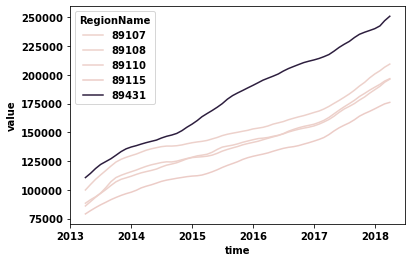

In [34]:
sns.lineplot(data = 
                 df_nv_5y_regions[
                 (df_nv_5y_regions['RegionName'] == 89108) |
                 (df_nv_5y_regions['RegionName'] == 89107) |
                 (df_nv_5y_regions['RegionName'] == 89110) |
                 (df_nv_5y_regions['RegionName'] == 89115) |
                 (df_nv_5y_regions['RegionName'] == 89431)
                ].reset_index(), x = 'time', y = 'value', hue = 'RegionName'
            )

## **Feature Engineering** 

In [35]:
from helper_functions import scrape_data

In [37]:
#scraped_data = [scrape_data(zipcode) for zipcode in list(set(df_nv['RegionName']))]

In [ ]:
missing_zipcodes = []

for i in scraped_data:
    if len(str(i['time'])) == 3:
        missing_zipcodes.append(i['RegionName'])

In [ ]:
print(missing_zipcodes)
print(f'number of missing zipcodes: {len(missing_zipcodes)}')

[89155, 89411, 89440, 89448, 89449, 89021, 89034]
number of missing zipcodes: 7


In [28]:
list_of_dfs = [pd.DataFrame(dict_) for dict_ in scraped_data if dict_['RegionName'] not in missing_zipcodes]

In [35]:
scraped_df = pd.concat(list_of_dfs)
scraped_df.head()

,time,RegionName,population,household_income,population_density
0,2005-01-31,89102,31083,57348,5799.067164
1,2005-02-28,89102,31115,57348,5805.093658
2,2005-03-31,89102,31179,57307,5816.983757
3,2005-04-30,89102,31268,57227,5833.711066
4,2005-05-31,89101,31390,57103,5856.390741


In [45]:
CPI_df = pd.read_csv('more_data/CPIAUCSL.csv')
realGDP_df = pd.read_csv('more_data/GDPC1.csv')
inflation_rate_df = pd.read_csv('more_data/FPCPITOTLZGUSA.csv')
unemployment_df = pd.read_csv('more_data/UNRATE.csv')

In [47]:
imported_df = reduce(lambda left,right: pd.merge(left,right,on='DATE'), 
                    [CPI_df, realGDP_df, inflation_rate_df, unemployment_df])

In [67]:
imported_df = imported_df.rename(columns={'DATE': 'time',
                                         'CPIAUCSL': 'CPI', 
                                         'GDPC1': 'real_GDP', 
                                         'FPCPITOTLZGUSA': 'inflation', 
                                         'UNRATE': 'unemployment_rate'})

In [63]:
imported_df['CPI'] = imported_df['CPI'].apply(lambda x: round(float(x), 2))
imported_df['real_GDP'] = imported_df['real_GDP'].apply(lambda x: round(x,2))
imported_df['inflation'] = imported_df['inflation'].apply(lambda x: round(x, 2))

In [70]:
imported_df.to_csv('more_data/US_stats.csv')

In [ ]:
imported_df['time'] = pd.to_datetime(imported_df['time'])
imported_df = imported_df.set_index('time')
imported_df = imported_df.resample('M').mean()
imported_df = imported_df.interpolate(method = 'polynomial', order = 2)

In [92]:
scraped_df

,time,RegionName,population,household_income,population_density
0,2005-01-31,89102,31083,57348,5799.067164
1,2005-02-28,89102,31115,57348,5805.093658
2,2005-03-31,89102,31179,57307,5816.983757
3,2005-04-30,89102,31268,57227,5833.711066
4,2005-05-31,89101,31390,57103,5856.390741
...,...,...,...,...,...
152,2017-09-30,89086,5087,43112,749.247577
153,2017-10-31,89086,5092,43524,749.957954
154,2017-11-30,89086,5097,43952,750.728077
155,2017-12-31,89086,5103,44424,751.609290


In [96]:
imported_df

,CPI,real_GDP,inflation,unemployment_rate
time,,,,
1960-01-31,29.590000,3262.060000,1.460000,5.200000
1960-02-29,29.612993,3263.031886,1.406176,5.410187
1960-03-31,29.637870,3265.146971,1.353003,5.615978
1960-04-30,29.662239,3268.252643,1.305837,5.796546
1960-05-31,29.687724,3272.555946,1.261534,5.963926
...,...,...,...,...
2019-09-30,257.908499,18740.902127,1.399432,3.752504
2019-10-31,258.157015,18664.333216,1.354237,3.696914
2019-11-30,258.388694,18581.759208,1.312099,3.637952


In [98]:
exogenous_variables = imported_df.reset_index().merge(scraped_df, how='inner', left_on = 'time', right_on = 'time')
exogenous_variables['time'] = exogenous_variables['time'].apply(lambda x: str(x)[:-12])
exogenous_variables['time'] = pd.to_datetime(exogenous_variables['time'])
exogenous_variables.head()
exogenous_variables.to_csv('more_data/exogenous_variables.csv')

In [132]:
exogenous_variables

,time,CPI,real_GDP,inflation,unemployment_rate,RegionName,population,household_income,population_density
0,2005-01-01,195.27,14901.27,3.39,5.3,89102,31083,57348,5799.067164
1,2005-01-01,195.27,14901.27,3.39,5.3,89103,37853,43935,5649.701493
2,2005-01-01,195.27,14901.27,3.39,5.3,89104,36505,36208,6426.936620
3,2005-01-01,195.27,14901.27,3.39,5.3,89107,32025,61450,5865.384615
4,2005-01-01,195.27,14901.27,3.39,5.3,89108,57746,38994,6423.359288
...,...,...,...,...,...,...,...,...,...
15055,2018-01-01,251.10,18606.79,2.44,4.0,89074,47190,77973,5255.011136
15056,2018-01-01,251.10,18606.79,2.44,4.0,89081,36100,49184,4832.663989
15057,2018-01-01,251.10,18606.79,2.44,4.0,89084,27190,66156,2487.648673
15058,2018-01-01,251.10,18606.79,2.44,4.0,89085,3920,74334,7538.461538


In [127]:
complete_df = exogenous_variables.merge(df_nv.reset_index(), left_on = ['time', 'RegionName'], right_on = ['time', 'RegionName'])

In [129]:
complete_df.to_csv('more_data/complete_df.csv')

In [131]:
complete_df.head()

,time,CPI,real_GDP,inflation,unemployment_rate,RegionName,population,household_income,population_density,SizeRank,City,Metro,CountyName,value
0,2005-01-01,195.27,14901.27,3.39,5.3,89102,31083,57348,5799.067164,2135,Las Vegas,Las Vegas,Clark,216000.0
1,2005-01-01,195.27,14901.27,3.39,5.3,89103,37853,43935,5649.701493,486,Las Vegas,Las Vegas,Clark,252000.0
2,2005-01-01,195.27,14901.27,3.39,5.3,89104,36505,36208,6426.936620,1961,Las Vegas,Las Vegas,Clark,198900.0
3,2005-01-01,195.27,14901.27,3.39,5.3,89107,32025,61450,5865.384615,2935,Las Vegas,Las Vegas,Clark,196800.0
4,2005-01-01,195.27,14901.27,3.39,5.3,89108,57746,38994,6423.359288,116,Las Vegas,Las Vegas,Clark,218500.0


In [20]:
complete_df = pd.read_csv('more_data/complete_df.csv').drop('Unnamed: 0', axis = 1)

## **Modelling**

In [21]:
def SARIMAX_model(zipcode, input_df):
    
    df = input_df[input_df['RegionName'] == zipcode]

    df = df.drop(['RegionName'], axis = 1)
    df = df.set_index('time')
    df.dropna(inplace = True)
    df = pd.get_dummies(df)

    cutoff = round(df.shape[0]*0.8)

    train = df[:cutoff]
    test = df[cutoff:]

    X_train = train.drop('value', axis = 1)
    y_train = train['value']
    X_test = test.drop('value', axis = 1)
    y_test = test['value']

    ss = StandardScaler()
    ss = ss.fit(X_train)
    scaled_train = pd.DataFrame(ss.transform(X_train), columns = X_train.columns)
    scaled_test = pd.DataFrame(ss.transform(X_test), columns = X_test.columns)

    pca = PCA(n_components = 0.9)
    pca_train = pd.DataFrame(pca.fit_transform(X_train))
    pca_test = pd.DataFrame(pca.transform(X_test))

    train_auto_arima = auto_arima(y_train, 
                                  exog = pca_train, 
                                  trace=True)
    
    train_auto_arima_summary = train_auto_arima.summary()    
    summary_dict = train_auto_arima.get_params(deep = True)
    
    order = list(summary_dict['order'])
    order_1 = order[0]
    order_2 = order[1]
    order_3 = order[2]

    seasonal_order = list(summary_dict['seasonal_order'])
    seasonal_order_1 = seasonal_order[0]
    seasonal_order_2 = seasonal_order[1]
    seasonal_order_3 = seasonal_order[2]
    seasonal_order_4 = seasonal_order[3]

    model = SARIMAX(endog = list(y_train),
                    exog = pca_train,
                    order = (order_1, order_2, order_3),
                    seasonal_order = (seasonal_order_1, seasonal_order_2, seasonal_order_3, seasonal_order_4),
                    enforce_stationarity = False,
                    enforce_invertibility = False).fit()

    forecasts = model.forecast(steps=len(test), exog = pca_test)
 
    mape = np.abs(np.mean((np.array(y_test) - np.array(forecasts)) / np.array(y_test)))

    future_df = df
    y = future_df['value'] 
    X = future_df.drop('value', axis = 1)

    ss = StandardScaler()
    X_scaled = pd.DataFrame(ss.fit_transform(X), columns = X.columns)

    pca = PCA(n_components = 0.9)
    pca_X = pd.DataFrame(pca.fit_transform(X_scaled))

    future_model = SARIMAX(
                           endog = list(y),
                           exog = pca_X,
                           order = (order_1, order_2, order_3),
                           seasonal_order = (seasonal_order_1, seasonal_order_2, seasonal_order_3, seasonal_order_4),
                           enforce_stationarity = False,
                           enforce_invertibility = False
                           ).fit()

    may_2018_predict = list(future_model.forecast(steps = 4, exog = pca_X.iloc[-4:]))[-1]

    final_dict = {zipcode: (may_2018_predict, mape, 'Sarimax')}

    return final_dict

In [47]:
SARIMAX_models = [SARIMAX_model(zipcode, complete_df) for zipcode in set(complete_df['RegionName'])]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2349.704, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2362.420, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2361.451, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2349.392, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2365.460, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2365.819, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2343.395, Time=0.24 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2352.140, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2364.373, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2369.594, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2351.679, T

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2497.303, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2475.381, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2489.500, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2484.439, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2492.538, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2477.330, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.191 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1935.750, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1943.558, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1949.231, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1937.727, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fi

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1592.568, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1604.562, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1608.406, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1600.879, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1605.603, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1589.883, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1597.349, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1586.601, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1592.491, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1622.015, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1596.571, Time=0.05 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 0.707 seconds
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=2193.656, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=218

In [48]:
SARIMAX_avg_mape = np.mean([list(i.values())[0][1] for i in SARIMAX_models])
SARIMAX_avg_mape

0.07898909169844506

In [58]:
for i in SARIMAX_models:
    for zipcode, values in i.items():
        SARIMAX_summary.update({zipcode: (values)})

In [60]:
SARIMAX_summary = {}
SARIMAX_summary

{89102: (219619.17294569654, 0.13692549573580381, 'Sarimax'),
 89103: (251018.2237947004, 0.013505008741549612, 'Sarimax'),
 89104: (205975.27941183094, 0.19120436461765367, 'Sarimax'),
 89107: (190038.05178903881, 0.11230525731737465, 'Sarimax'),
 89108: (205291.41707541235, 0.06412060443947959, 'Sarimax'),
 89109: (310200.0, 0.06120353804433491, 'Sarimax'),
 89110: (190630.55196842062, 0.06780326590033217, 'Sarimax'),
 89113: (306916.7378836556, 0.02471122961514557, 'Sarimax'),
 89115: (170618.151850568, 0.07288063680880344, 'Sarimax'),
 89117: (339011.709428471, 0.11927652568091235, 'Sarimax'),
 89118: (264104.09554394195, 0.09822506578292199, 'Sarimax'),
 89119: (244775.34406168346, 0.06252093576783549, 'Sarimax'),
 89120: (262471.2054108442, 0.21512536232016852, 'Sarimax'),
 89121: (203911.96514430724, 0.11186434231331001, 'Sarimax'),
 89122: (207761.12401967685, 0.014471367203184187, 'Sarimax'),
 89123: (311184.003078653, 0.020994824115674448, 'Sarimax'),
 89124: (312882.36693125

In [63]:
def SARIMA_model(zipcode, input_df):
    
    df = input_df[input_df['RegionName'] == zipcode]

    df = df.drop(['RegionName'], axis = 1)
    df = df.set_index('time')
    df.dropna(inplace = True)
    df = pd.get_dummies(df)

    cutoff = round(df.shape[0]*0.8)

    train = df['value'][:cutoff]
    test = df['value'][cutoff:]

    train_auto_arima = auto_arima(train, 
                                  trace=True)
    
    train_auto_arima_summary = train_auto_arima.summary()    
    summary_dict = train_auto_arima.get_params(deep = True)
    
    order = list(summary_dict['order'])
    order_1 = order[0]
    order_2 = order[1]
    order_3 = order[2]

    seasonal_order = list(summary_dict['seasonal_order'])
    seasonal_order_1 = seasonal_order[0]
    seasonal_order_2 = seasonal_order[1]
    seasonal_order_3 = seasonal_order[2]
    seasonal_order_4 = seasonal_order[3]

    model = SARIMAX(endog = list(train),
                    order = (order_1, order_2, order_3),
                    seasonal_order = (seasonal_order_1, seasonal_order_2, seasonal_order_3, seasonal_order_4),
                    enforce_stationarity = False,
                    enforce_invertibility = False).fit()

    forecasts = model.forecast(steps=len(test))
 
    mape = np.abs(np.mean((np.array(test) - np.array(forecasts)) / np.array(test)))

    predictions_dict = {'forecasts': forecasts, 'test': test, 'zipcode': zipcode}

    future_df = df
    y = future_df['value'] 

    future_model = SARIMAX(endog = list(y),
                           order = (order_1, order_2, order_3),
                           seasonal_order = (seasonal_order_1, seasonal_order_2, seasonal_order_3, seasonal_order_4),
                           enforce_stationarity = False,
                           enforce_invertibility = False).fit()

    may_2018_predict = list(future_model.forecast(steps = 4))[-1]

    final_dict = {zipcode: (may_2018_predict, mape, 'SARIMA')}

    return final_dict, predictions_dict

In [64]:
SARIMA_models = [SARIMA_model(zipcode, complete_df) for zipcode in set(complete_df['RegionName'])]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2349.704, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=2362.420, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=2361.451, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2349.392, Time=0.21 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=2365.460, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2365.819, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2343.395, Time=0.26 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2352.140, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2364.373, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2369.594, Time=0.14 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2351.679, T

C:\Users\Damola\anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=1832.003, Time=0.00 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=1834.036, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=1835.048, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=1833.977, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.430 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=564.245, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=556.639, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=560.113, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=558.603, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=563.583, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=560.654, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time

In [71]:
SARIMA_models[0][0].items()

dict_items([(89102, (219569.1389415926, 0.14147840001613393, 'SARIMA'))])

In [65]:
SARIMA_avg_mape = np.mean(value for i[0].items() in SARIMA_models])
SARIMA_avg_mape

AttributeError: 'tuple' object has no attribute 'values'

In [64]:
SARIMA_summary = {}
for i in SARIMA_models:
    for zipcode, values in i.items():
        SARIMA_summary.update({zipcode: (values)})

In [1]:
SARIMA_summary

NameError: name 'SARIMA_summary' is not defined

In [66]:
import pickle

In [73]:
pickle.dump(SARIMAX_summary, open('SARIMAX_summary.pickl', 'ab'))
open('SARIMAX_model.pickl', 'ab').close()

In [74]:
pickle.dump(SARIMA_summary, open('SARIMA_summary.pickl', 'ab'))
open('SARIMAX_model.pickl', 'ab').close()